In [9]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling as ResamplingEnum
from rasterio.mask import mask
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

Define Paths

In [ ]:
raw_dir = Path("../data/raw/spread")
processed_dir = Path("../data/processed/spread")
processed_dir.mkdir(parents=True, exist_ok=True)

fire_events = [
    "Dixie",
    "Camp",
    "Bootleg",
    "Caldor",
    "Troublesome",
    "Carr",
    "Thomas",
    "Creek",
    "Woolsey",
    "Glass"
]

Helper Functions

In [4]:
def load_raster(path):
    """Load a raster as (array, profile)"""
    with rasterio.open(path) as src:
        arr = src.read(1)
        profile = src.profile
    return arr, profile


def align_to_reference(ref_profile, src_arr, src_profile, resampling=ResamplingEnum.bilinear):
    """Aligns a raster to reference CRS, transform, and shape."""
    dst_arr = np.empty((ref_profile["height"], ref_profile["width"]), dtype=np.float32)

    reproject(
        source=src_arr,
        destination=dst_arr,
        src_transform=src_profile["transform"],
        src_crs=src_profile["crs"],
        dst_transform=ref_profile["transform"],
        dst_crs=ref_profile["crs"],
        resampling=resampling
    )
    return dst_arr


def normalize(arr, min_val=None, max_val=None):
    """Simple min-max normalization."""
    arr = arr.astype(np.float32)
    if min_val is None:
        min_val = np.nanmin(arr)
    if max_val is None:
        max_val = np.nanmax(arr)
    norm = (arr - min_val) / (max_val - min_val + 1e-6)
    norm[arr == ref_nodata] = np.nan
    return norm


def encode_landcover(landcover_arr):
    """Basic landcover integer encoding."""
    unique_classes = np.unique(landcover_arr[~np.isnan(landcover_arr)])
    mapping = {cls: i for i, cls in enumerate(unique_classes)}
    encoded = np.vectorize(mapping.get)(landcover_arr)
    return encoded, mapping

Preprocessing Loop

In [7]:
summary_records = []

for fire_name in tqdm(fire_events, desc="Processing Fires"):

    fire_dir = raw_dir / fire_name
    out_dir = processed_dir / fire_name
    out_dir.mkdir(parents=True, exist_ok=True)

    burned_path = fire_dir / "burned_area.tif"
    if not burned_path.exists():
        print(f"[Warning] Missing burned_area.tif for {fire_name}, skipping.")
        continue

    burned, ref_profile = load_raster(burned_path)
    ref_nodata = ref_profile.get("nodata", -9999)
    burned = np.where(burned > 0, 1, 0).astype(np.uint8)

    layers = {"burned_area": burned}

    feature_files = {
        "ndvi_prefire": "ndvi_prefire.tif",
        "landcover": "landcover.tif",
        "temperature_mean": "temperature_mean.tif",
        "precipitation_sum": "precipitation_sum.tif",
        "elevation": "elevation.tif",
    }

    for key, filename in feature_files.items():
        fpath = fire_dir / filename
        if not fpath.exists():
            print(f"[Warning] {filename} missing for {fire_name}")
            continue
        arr, prof = load_raster(fpath)
        aligned = align_to_reference(ref_profile, arr, prof)
        layers[key] = aligned

# -- Cleaning and Normalization -- #
    ndvi = normalize(layers["ndvi_prefire"])
    temp = normalize(layers["temperature_mean"])
    precip = normalize(layers["precipitation_sum"])
    elev = normalize(layers["elevation"])
    landcover_encoded, mapping = encode_landcover(layers["landcover"])

    stacked = np.stack([ndvi, temp, precip, elev, landcover_encoded], axis=-1)
    target = burned

    valid_mask = ~np.isnan(stacked).any(axis=-1)
    stacked[~valid_mask] = 0

    np.save(out_dir / "features.npy", stacked)
    np.save(out_dir / "target.npy", target)

    metadata = {
        "fire": fire_name,
        "shape": stacked.shape,
        "valid_pixels": int(valid_mask.sum()),
        "coverage_pct": round(100 * valid_mask.sum() / valid_mask.size, 2),
    }
    summary_records.append(metadata)

    with rasterio.open(
        out_dir / "stacked_features.tif",
        "w",
        driver="GTiff",
        height=ref_profile["height"],
        width=ref_profile["width"],
        count=stacked.shape[-1],
        dtype=np.float32,
        crs=ref_profile["crs"],
        transform=ref_profile["transform"]
    ) as dst:
        for i in range(stacked.shape[-1]):
            dst.write(stacked[..., i], i + 1)

print("Preprocessing complete for all fires.")


Processing Fires: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s]

Preprocessing complete for all fires.


Save Summary

In [8]:
df_summary = pd.DataFrame(summary_records)
df_summary.to_csv(processed_dir / "spread_preprocessing_summary.csv", index=False)
df_summary

,fire,shape,valid_pixels,coverage_pct
0,Dixie,"(402, 520, 5)",209040,100.00
1,Camp,"(501, 652, 5)",293919,89.98
2,Bootleg,"(402, 542, 5)",217884,100.00
3,Caldor,"(401, 511, 5)",204911,100.00
4,Troublesome,"(401, 522, 5)",209322,100.00
5,Carr,"(402, 526, 5)",211452,100.00
6,Thomas,"(402, 484, 5)",194568,100.00
7,Creek,"(402, 501, 5)",201402,100.00
8,Woolsey,"(501, 605, 5)",12221,4.03
9,Glass,"(401, 511, 5)",204911,100.00


Visual Check

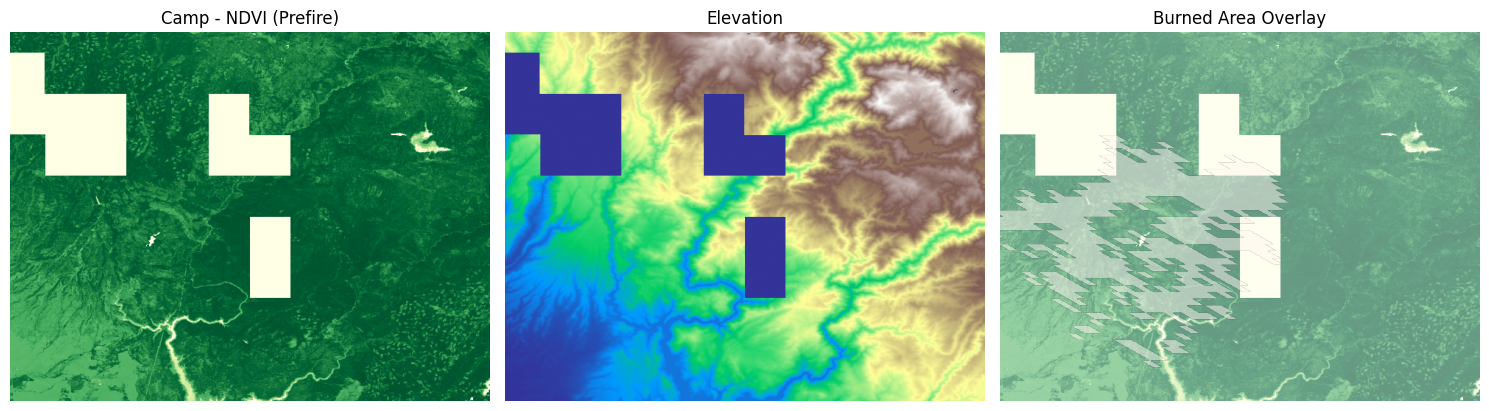

In [10]:
example_fire = "Camp"
fire_dir = processed_dir / example_fire

features = np.load(fire_dir / "features.npy")
target = np.load(fire_dir / "target.npy")

ndvi = features[..., 0]
elev = features[..., 3]

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(ndvi, cmap="YlGn")
axs[0].set_title(f"{example_fire} - NDVI (Prefire)")

axs[1].imshow(elev, cmap="terrain")
axs[1].set_title("Elevation")

axs[2].imshow(ndvi, cmap="YlGn", alpha=0.6)
axs[2].imshow(np.where(target == 1, 1, np.nan), cmap="Reds", alpha=0.5)
axs[2].set_title("Burned Area Overlay")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()